In [52]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import pandas as pd
from tqdm.auto import tqdm
import utils as U
import time


In [53]:
def permute(array, patch_len, permute_freq, permute_strategy, truncate=False):
    # seed
    random.seed(42)
    np.random.seed(42)
    if not truncate:
        """Permute the array by patch_len, permute_freq, permute_strategy"""
        assert array.ndim == 2, "array should be 2D"
        assert array.shape[0] > array.shape[1], "array should have longer time dimension than feature dimension"
        assert array.shape[0] % patch_len == 0, "array.shape[0] should be divisible by patch_len"
        assert array.shape[0] // patch_len > 2, "There should be at least 3 patches for each feature dimension"
        assert permute_strategy in ["random", "vicinity", "farthest"]
        assert permute_freq >= 0
        assert patch_len > 0

        if permute_freq == 0:
            # print('no permutation')
            return array
        else:
            # print(f"permute_freq: {permute_freq}, permute_strategy: {permute_strategy}")
            temp_array = array.copy()
            seq_len, num_features = temp_array.shape
            num_patches = seq_len // patch_len
            # print('num_patches:', num_patches)
            for feature in range(num_features):
                # print('')
                patches = [temp_array[i * patch_len : (i + 1) * patch_len, feature] for i in range(num_patches)]
                # print(f"original patches: {patches}")

                for _ in range(permute_freq):
                    if permute_strategy == "random":
                        idx1, idx2 = random.sample(range(num_patches), 2)
                    elif permute_strategy == "vicinity":
                        idx1 = random.randint(0, num_patches - 2)
                        idx2 = idx1 + 1
                    elif permute_strategy == "farthest":
                        idx1, idx2 = random.sample(range(num_patches), 2)
                        while abs(idx1 - idx2) < 2:
                            idx1, idx2 = random.sample(range(num_patches), 2)

                    tmp_patch = patches[idx1].copy()
                    patches[idx1] = patches[idx2].copy()
                    patches[idx2] = tmp_patch.copy()

                    # print(f"idx1: {idx1}, idx2: {idx2}")

                    del tmp_patch, idx1, idx2

                for i, patch in enumerate(patches):
                    temp_array[i * patch_len : (i + 1) * patch_len, feature] = patch
                # print(f"permuted patches: {patches}")
            return temp_array
    else:
        """Permute the array by patch_len, permute_freq, permute_strategy"""
        assert array.ndim == 2, "array should be 2D"
        assert array.shape[0] > array.shape[1], "array should have longer time dimension than feature dimension"
        assert array.shape[0] // patch_len > 2, "There should be at least 3 patches for each feature dimension"
        assert permute_strategy in ["random", "vicinity", "farthest"]
        assert permute_freq >= 0
        assert patch_len > 0

        temp_array = array.copy()
        is_divisible = array.shape[0] % patch_len == 0
        if not is_divisible:
            remain = array.shape[0] % patch_len
            num_patch = array.shape[0] // patch_len
            len_to_drop = array.shape[0] - (num_patch * patch_len)
            temp_array = array[:-len_to_drop].copy()
            # print(f"Original Shape: [{array.shape}], Test Shape: [{temp_array.shape}]")
        
        assert temp_array.shape[0] % patch_len == 0, "Patch len is still not divisible"

        if permute_freq == 0:
            # print('no permutation')
            return array
        else:
            # print(f"permute_freq: {permute_freq}, permute_strategy: {permute_strategy}")
            seq_len, num_features = temp_array.shape
            num_patches = seq_len // patch_len
            # print('num_patches:', num_patches)
            for feature in range(num_features):
                # print('')
                patches = [temp_array[i * patch_len : (i + 1) * patch_len, feature] for i in range(num_patches)]
                # print(f"original patches: {patches}")

                for _ in range(permute_freq):
                    if permute_strategy == "random":
                        idx1, idx2 = random.sample(range(num_patches), 2)
                    elif permute_strategy == "vicinity":
                        idx1 = random.randint(0, num_patches - 2)
                        idx2 = idx1 + 1
                    elif permute_strategy == "farthest":
                        idx1, idx2 = random.sample(range(num_patches), 2)
                        while abs(idx1 - idx2) < 2:
                            idx1, idx2 = random.sample(range(num_patches), 2)

                    tmp_patch = patches[idx1].copy()
                    patches[idx1] = patches[idx2].copy()
                    patches[idx2] = tmp_patch.copy()

                    # print(f"idx1: {idx1}, idx2: {idx2}")

                    del tmp_patch, idx1, idx2

                for i, patch in enumerate(patches):
                    temp_array[i * patch_len : (i + 1) * patch_len, feature] = patch

            # add back zeros, this part will be ignored by the model.
            # This is done, to match the original seq_len parameter
            
            if not is_divisible:
                zero_pad = np.zeros((len_to_drop , array.shape[1]))
                temp_array = np.concatenate([temp_array, zero_pad])
            
            return temp_array

In [54]:
sample_gaussian_noise = np.random.normal(0, 1, 100)
print(f"Shape of sample_gaussian_noise: {sample_gaussian_noise.shape}")
permuted_gaussian = permute(sample_gaussian_noise.reshape(-1, 1), patch_len=5, permute_freq=10, permute_strategy='random', truncate=False)

Shape of sample_gaussian_noise: (100,)


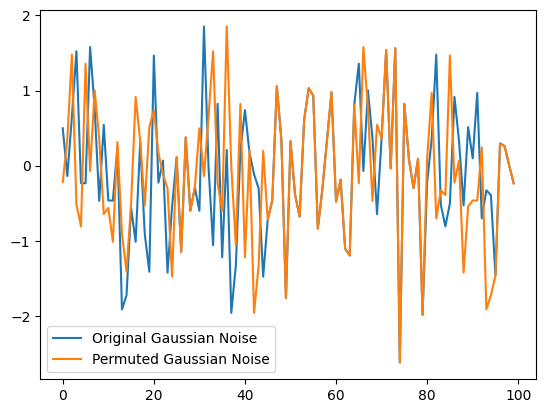

In [55]:
plt.plot(sample_gaussian_noise, label='Original Gaussian Noise')
plt.plot(permuted_gaussian, label='Permuted Gaussian Noise')
plt.legend()

In [56]:
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]


def autocorrelation_via_fft(x):
    # Convert x to a zero-padded array with length equal to the nearest power of 2
    # This step is optional but improves FFT computation speed
    n = len(x)
    n_padded = 2 ** np.ceil(np.log2(2*n - 1)).astype(int)
    x_padded = np.pad(x, (0, n_padded - n), mode='constant')

    # Compute the FFT of the zero-padded array
    Fx = np.fft.fft(x_padded)

    # Compute the power spectrum (magnitude squared of the FFT)
    power_spectrum = np.abs(Fx) ** 2

    # Compute the inverse FFT of the power spectrum to get the autocorrelation
    result = np.fft.ifft(power_spectrum).real

    # Slice the result to obtain the autocorrelation for positive lags
    return result[:n]

# compute cosine similarity between two arrays
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [57]:
number = np.arange(100)
print(number)
np.correlate(number, number, mode='full')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


array([     0,     99,    296,    590,    980,   1465,   2044,   2716,
         3480,   4335,   5280,   6314,   7436,   8645,   9940,  11320,
        12784,  14331,  15960,  17670,  19460,  21329,  23276,  25300,
        27400,  29575,  31824,  34146,  36540,  39005,  41540,  44144,
        46816,  49555,  52360,  55230,  58164,  61161,  64220,  67340,
        70520,  73759,  77056,  80410,  83820,  87285,  90804,  94376,
        98000, 101675, 105400, 109174, 112996, 116865, 120780, 124740,
       128744, 132791, 136880, 141010, 145180, 149389, 153636, 157920,
       162240, 166595, 170984, 175406, 179860, 184345, 188860, 193404,
       197976, 202575, 207200, 211850, 216524, 221221, 225940, 230680,
       235440, 240219, 245016, 249830, 254660, 259505, 264364, 269236,
       274120, 279015, 283920, 288834, 293756, 298685, 303620, 308560,
       313504, 318451, 323400, 328350, 323400, 318451, 313504, 308560,
       303620, 298685, 293756, 288834, 283920, 279015, 274120, 269236,
      

In [58]:
np.correlate(sample_gaussian_noise, sample_gaussian_noise, mode='full').shape

(199,)

In [59]:
now = time.time()
gaussian_acf = autocorrelation(sample_gaussian_noise)
permute_acf = autocorrelation(sample_gaussian_noise)
print(gaussian_acf.shape)


print(f"acf-cos:{1-cosine_similarity(gaussian_acf, permute_acf):.3f}")
print(f"Time taken: {time.time() - now}")

(100,)
acf-cos:0.000
Time taken: 0.0011298656463623047


In [60]:
# create a step function, where order is highly important
# set seed
np.random.seed(42)
random.seed(42)
step_function = np.zeros(500)
# 0 - 10 : 1, 11 - 20 : 2, 21 - 30 : 3, 31 - 40 : 4, 41 - 50 : 5, 51 - 60 : 6, 61 - 70 : 7, 71 - 80 : 8, 81 - 90 : 9, 91 - 100 : 10
for i in range(50):
    step_function[i*10:(i+1)*10] = i+1
# normalize
step_function = (step_function - np.mean(step_function)) / np.std(step_function)

permute_step = permute(step_function.reshape(-1, 1), patch_len=10, permute_freq=1000, permute_strategy='random', truncate=False)
permute_step = permute_step.reshape(-1)


now = time.time()
step_acf = autocorrelation(step_function)
permutestep_acf = autocorrelation(permute_step)

print(f"acf-cos:{1-cosine_similarity(step_acf, permutestep_acf)}")
print(f"Time taken: {time.time() - now}")


acf-cos:0.9279177643760836
Time taken: 0.0005505084991455078


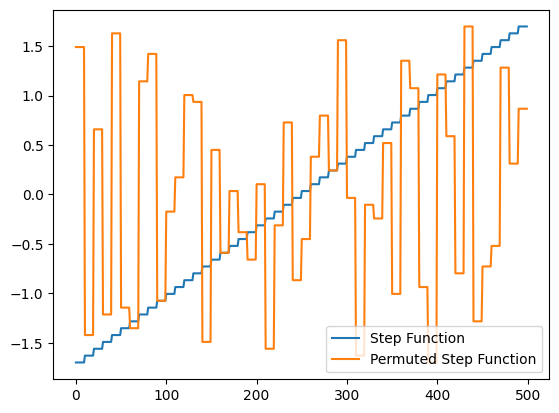

In [44]:
plt.plot(step_function, label='Step Function')
plt.plot(permute_step, label='Permuted Step Function')
plt.legend()